In [7]:
import mne
from helpers import *
%matplotlib widget

In [8]:
DS_NUM = 'ds004789'
TASKNUM = 'FR1'
SUB_IDX = 0
SES = 0

In [9]:
!datalad install https://github.com/OpenNeuroDatasets/{DS_NUM}.git

In [10]:
participants = pd.read_csv(f'{DS_NUM}/participants.tsv', sep='\t')

subjects = participants['participant_id'].tolist()
print(f'There are {len(subjects)} participants for task {TASKNUM}, up to index {len(subjects) - 1}')

sub_id = subjects[SUB_IDX]

There are 280 participants for task FR1, up to index 279


In [11]:
ieeg_prefix = f'{DS_NUM}/{sub_id}/ses-{SES}/ieeg'
if not os.path.exists(ieeg_prefix): # check if ieeg folder exists
    raise ValueError(f'No ieeg data for {sub_id} ses-{SES}')
prefix = ieeg_prefix + f'/{sub_id}_ses-{SES}_task-{TASKNUM}'
file = prefix + '_space-MNI152NLin6ASym_electrodes.tsv'

Subject sub-R1001P electrodes counts: {'SEEG': 22, 'ECOG': 66}


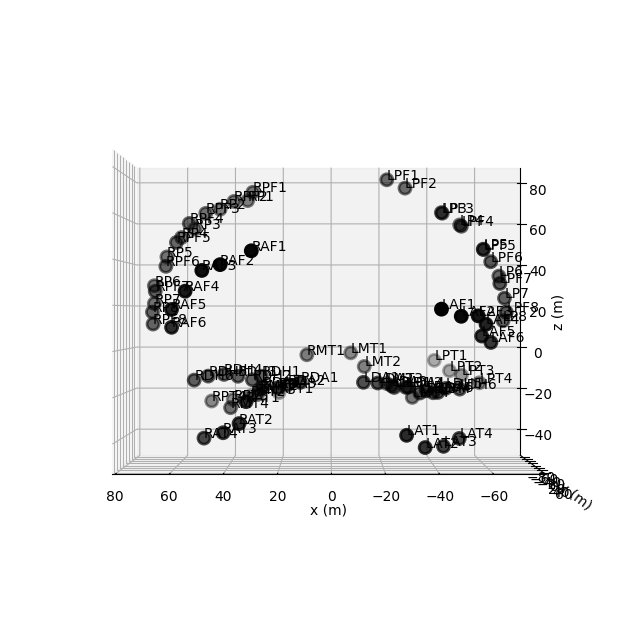

In [12]:
# Load electrode data
df = pd.read_csv(file, sep="\t")

_, _, electrodes, _, _, _ = get_sub_info(DS_NUM, TASKNUM, sub_id, SES, print_info=False)
print(f'Subject {sub_id} electrodes counts: {dict({elec:len(electrodes[elec]) for elec in electrodes})}')

# Use coordinates in millimeters (MNI space)
ch_names = df['name'].tolist()
pos = df[['x', 'y', 'z']].to_numpy()  # Keep coordinates in mm
# X is left(-)/right(+)
# Y is dorsal(-)/ventral(+)
# Z is inferior(-)/superior(+)

# Dummy fiducials (millimeters)
nasion = (0.0, 85.0, -20.0)
lpa    = (-70.0, 0.0, -5.0)
rpa    = (70.0, 0.0, -5.0)

montage = mne.channels.make_dig_montage(
    ch_pos=dict(zip(ch_names, pos)),
    nasion=nasion,
    lpa=lpa,
    rpa=rpa,
    coord_frame='mni_tal'
)

info = mne.create_info(ch_names=ch_names, sfreq=1000., ch_types='ecog')
raw = mne.io.RawArray(np.zeros((len(ch_names), 1)), info, verbose=False)
_ = raw.set_montage(montage)

fig = raw.plot_sensors(kind='3d', show_names=True, block=True)
_ = fig.gca().set_xlabel('X (right/left, mm)')
_ = fig.gca().set_ylabel('Y (ventral/dorsal mm)')
_ = fig.gca().set_zlabel('Z (superior/inferior  mm)')
_ = fig.gca().set_title('')  # Remove the title

for text in fig.gca().texts:
    text.set_fontsize(8)

# Note monopolar channels would be more prone to noise because would be a greater distance between the electrode and reference (seen in figures), while bipolar channels would be less prone to noise because the reference and electrode are closer together.

# I believe the reference electrode for the monopolar channels is not available in this dataset